<a href="https://colab.research.google.com/github/nitinmalviya326/deep-learning-lab/blob/main/Experiment-4/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib seaborn scikit-learn tqdm -q

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [2]:
drive.mount('/content/drive')

os.makedirs('/content/drive/MyDrive/DL_Lab/Experiment4_CIFAR10', exist_ok=True)
os.makedirs('/content/models', exist_ok=True)
os.makedirs('/content/results', exist_ok=True)

print("Directories created successfully!")

Mounted at /content/drive
Directories created successfully!


In [3]:
# Data transformations
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2470, 0.2435, 0.2616])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2470, 0.2435, 0.2616])
])

# Download datasets
print("Downloading CIFAR-10...")
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

# Create loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {classes}")

100%|██████████| 170M/170M [00:18<00:00, 9.17MB/s]



Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


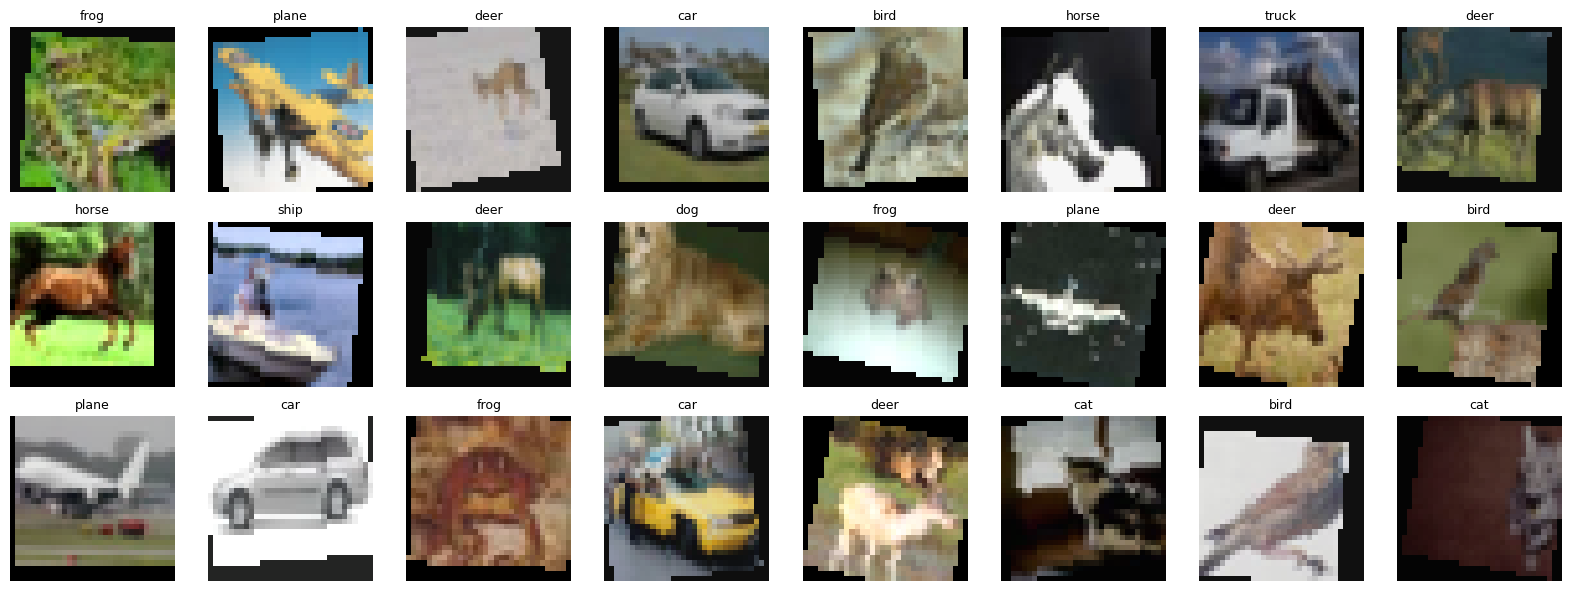

In [4]:
def imshow(img):
    img = img * torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    return np.transpose(img.numpy(), (1, 2, 0))

dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(3, 8, figsize=(16, 6))
for i, ax in enumerate(axes.flat):
    if i < 24:
        ax.imshow(imshow(images[i]))
        ax.set_title(classes[labels[i]], fontsize=9)
        ax.axis('off')
plt.tight_layout()
plt.savefig('/content/results/cifar10_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
class CIFAR10_CNN(nn.Module):
    def __init__(self, activation='relu', num_classes=10):
        super(CIFAR10_CNN, self).__init__()

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.2)

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.2)

        # Block 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.3)

        # Block 3
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.4)

        # FC layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.activation(self.bn2(self.conv2(
            self.activation(self.bn1(self.conv1(x))))))))
        x = self.pool2(self.dropout2(self.activation(self.bn4(self.conv4(
            self.activation(self.bn3(self.conv3(x))))))))
        x = self.pool3(self.dropout3(self.activation(self.bn6(self.conv6(
            self.activation(self.bn5(self.conv5(x))))))))

        x = x.view(x.size(0), -1)
        x = self.dropout4(self.activation(self.bn_fc1(self.fc1(x))))
        x = self.dropout5(self.activation(self.bn_fc2(self.fc2(x))))
        return self.fc3(x)

model = CIFAR10_CNN('relu').to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Parameters: 3,380,298


In [6]:
def init_weights_xavier(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def init_weights_kaiming(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def init_weights_random(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.uniform_(m.weight, -0.1, 0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

print("Initialization functions ready!")

Initialization functions ready!


In [7]:
def train_model(model, train_loader, test_loader, criterion, optimizer,
                num_epochs=3, device='cuda', model_name='model'):
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    best_test_acc = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': f'{running_loss/len(pbar):.4f}',
                            'acc': f'{100.*correct/total:.2f}%'})

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Testing
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = 100. * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print('-' * 60)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'test_acc': test_acc,
            }, f'/content/models/{model_name}_best.pth')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'best_test_acc': best_test_acc
    }

print("Training function ready!")

Training function ready!


In [8]:
def plot_history(history, title, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history['train_losses'], 'o-', label='Train', linewidth=2)
    axes[0].plot(history['test_losses'], 's-', label='Test', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train_accs'], 'o-', label='Train', linewidth=2)
    axes[1].plot(history['test_accs'], 's-', label='Test', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("Plotting function ready!")

Plotting function ready!


In [10]:
activations = ['relu', 'tanh', 'leaky_relu']
initializations = {
    'xavier': init_weights_xavier,
    'kaiming': init_weights_kaiming,
    'random': init_weights_random
}
optimizers_config = ['sgd', 'adam', 'rmsprop']

all_results = {}
best_config = None
best_acc = 0.0

total_experiments = 27
experiment_num = 0

print(f"Starting {total_experiments} experiments (3 epochs each)...\n")

for activation in activations:
    for init_name, init_func in initializations.items():
        for opt_name in optimizers_config:
            experiment_num += 1
            config_name = f"{activation}_{init_name}_{opt_name}"

            print(f"\n{'='*80}")
            print(f"Experiment {experiment_num}/{total_experiments}: {config_name}")
            print(f"{'='*80}\n")

            model = CIFAR10_CNN(activation=activation).to(device)
            model.apply(init_func)

            if opt_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.01,
                                     momentum=0.9, weight_decay=5e-4)
            elif opt_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001,
                                      weight_decay=5e-4)
            else:
                optimizer = optim.RMSprop(model.parameters(), lr=0.001,
                                         weight_decay=5e-4)

            criterion = nn.CrossEntropyLoss()

            history = train_model(model, train_loader, test_loader, criterion,
                                optimizer, num_epochs=3, device=device,
                                model_name=config_name)

            all_results[config_name] = history

            if history['best_test_acc'] > best_acc:
                best_acc = history['best_test_acc']
                best_config = config_name

            print(f"Best Test Acc: {history['best_test_acc']:.2f}%")
            print(f"Current best: {best_config} ({best_acc:.2f}%)")

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED!")
print(f"Best: {best_config} - {best_acc:.2f}%")
print("="*80)


Starting 27 experiments (3 epochs each)...


Experiment 1/27: relu_xavier_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.47it/s, loss=2.0406, acc=25.95%]


Epoch [1/3]
Train Loss: 2.0406, Train Acc: 25.95%
Test Loss: 1.5686, Test Acc: 41.63%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s, loss=1.7178, acc=36.37%]


Epoch [2/3]
Train Loss: 1.7178, Train Acc: 36.37%
Test Loss: 1.4022, Test Acc: 47.70%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.52it/s, loss=1.5856, acc=41.37%]


Epoch [3/3]
Train Loss: 1.5856, Train Acc: 41.37%
Test Loss: 1.3142, Test Acc: 50.89%
------------------------------------------------------------
Best Test Acc: 50.89%
Current best: relu_xavier_sgd (50.89%)

Experiment 2/27: relu_xavier_adam



Epoch 1/3: 100%|██████████| 391/391 [00:38<00:00, 10.28it/s, loss=1.9185, acc=31.00%]


Epoch [1/3]
Train Loss: 1.9185, Train Acc: 31.00%
Test Loss: 1.3570, Test Acc: 50.26%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.44it/s, loss=1.5078, acc=44.87%]


Epoch [2/3]
Train Loss: 1.5078, Train Acc: 44.87%
Test Loss: 1.1411, Test Acc: 59.01%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:36<00:00, 10.86it/s, loss=1.3210, acc=52.34%]


Epoch [3/3]
Train Loss: 1.3210, Train Acc: 52.34%
Test Loss: 1.0027, Test Acc: 63.49%
------------------------------------------------------------
Best Test Acc: 63.49%
Current best: relu_xavier_adam (63.49%)

Experiment 3/27: relu_xavier_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s, loss=1.8698, acc=32.14%]


Epoch [1/3]
Train Loss: 1.8698, Train Acc: 32.14%
Test Loss: 1.4404, Test Acc: 49.41%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.47it/s, loss=1.4947, acc=45.71%]


Epoch [2/3]
Train Loss: 1.4947, Train Acc: 45.71%
Test Loss: 1.1836, Test Acc: 56.42%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.43it/s, loss=1.3222, acc=52.71%]


Epoch [3/3]
Train Loss: 1.3222, Train Acc: 52.71%
Test Loss: 1.0627, Test Acc: 61.51%
------------------------------------------------------------
Best Test Acc: 61.51%
Current best: relu_xavier_adam (63.49%)

Experiment 4/27: relu_kaiming_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s, loss=2.0394, acc=25.84%]


Epoch [1/3]
Train Loss: 2.0394, Train Acc: 25.84%
Test Loss: 1.5503, Test Acc: 42.51%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s, loss=1.7274, acc=35.74%]


Epoch [2/3]
Train Loss: 1.7274, Train Acc: 35.74%
Test Loss: 1.3926, Test Acc: 47.58%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s, loss=1.6096, acc=40.41%]


Epoch [3/3]
Train Loss: 1.6096, Train Acc: 40.41%
Test Loss: 1.2956, Test Acc: 51.74%
------------------------------------------------------------
Best Test Acc: 51.74%
Current best: relu_xavier_adam (63.49%)

Experiment 5/27: relu_kaiming_adam



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.43it/s, loss=1.9382, acc=30.32%]


Epoch [1/3]
Train Loss: 1.9382, Train Acc: 30.32%
Test Loss: 1.4092, Test Acc: 47.37%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s, loss=1.5467, acc=42.94%]


Epoch [2/3]
Train Loss: 1.5467, Train Acc: 42.94%
Test Loss: 1.1769, Test Acc: 57.42%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:36<00:00, 10.85it/s, loss=1.3521, acc=51.01%]


Epoch [3/3]
Train Loss: 1.3521, Train Acc: 51.01%
Test Loss: 1.0178, Test Acc: 62.71%
------------------------------------------------------------
Best Test Acc: 62.71%
Current best: relu_xavier_adam (63.49%)

Experiment 6/27: relu_kaiming_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.53it/s, loss=1.8580, acc=32.55%]


Epoch [1/3]
Train Loss: 1.8580, Train Acc: 32.55%
Test Loss: 1.4500, Test Acc: 45.59%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.49it/s, loss=1.4690, acc=46.31%]


Epoch [2/3]
Train Loss: 1.4690, Train Acc: 46.31%
Test Loss: 1.1225, Test Acc: 59.24%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s, loss=1.3012, acc=53.53%]


Epoch [3/3]
Train Loss: 1.3012, Train Acc: 53.53%
Test Loss: 1.0135, Test Acc: 64.28%
------------------------------------------------------------
Best Test Acc: 64.28%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 7/27: relu_random_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:35<00:00, 10.89it/s, loss=2.0997, acc=21.67%]


Epoch [1/3]
Train Loss: 2.0997, Train Acc: 21.67%
Test Loss: 1.7756, Test Acc: 34.00%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.49it/s, loss=1.8429, acc=30.29%]


Epoch [2/3]
Train Loss: 1.8429, Train Acc: 30.29%
Test Loss: 1.5834, Test Acc: 39.80%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.48it/s, loss=1.7336, acc=34.68%]


Epoch [3/3]
Train Loss: 1.7336, Train Acc: 34.68%
Test Loss: 1.4544, Test Acc: 45.63%
------------------------------------------------------------
Best Test Acc: 45.63%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 8/27: relu_random_adam



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.84it/s, loss=1.8882, acc=30.57%]


Epoch [1/3]
Train Loss: 1.8882, Train Acc: 30.57%
Test Loss: 1.3807, Test Acc: 49.36%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s, loss=1.5326, acc=43.98%]


Epoch [2/3]
Train Loss: 1.5326, Train Acc: 43.98%
Test Loss: 1.1969, Test Acc: 56.22%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:38<00:00, 10.27it/s, loss=1.3561, acc=51.00%]


Epoch [3/3]
Train Loss: 1.3561, Train Acc: 51.00%
Test Loss: 0.9937, Test Acc: 64.15%
------------------------------------------------------------
Best Test Acc: 64.15%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 9/27: relu_random_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.48it/s, loss=1.7904, acc=34.24%]


Epoch [1/3]
Train Loss: 1.7904, Train Acc: 34.24%
Test Loss: 1.3513, Test Acc: 50.20%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s, loss=1.4532, acc=46.94%]


Epoch [2/3]
Train Loss: 1.4532, Train Acc: 46.94%
Test Loss: 1.1371, Test Acc: 58.66%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s, loss=1.2879, acc=53.79%]


Epoch [3/3]
Train Loss: 1.2879, Train Acc: 53.79%
Test Loss: 1.0770, Test Acc: 60.49%
------------------------------------------------------------
Best Test Acc: 60.49%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 10/27: tanh_xavier_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.35it/s, loss=1.9351, acc=30.53%]


Epoch [1/3]
Train Loss: 1.9351, Train Acc: 30.53%
Test Loss: 1.5448, Test Acc: 42.83%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.35it/s, loss=1.6535, acc=39.46%]


Epoch [2/3]
Train Loss: 1.6535, Train Acc: 39.46%
Test Loss: 1.3775, Test Acc: 49.74%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:35<00:00, 10.89it/s, loss=1.5579, acc=43.17%]


Epoch [3/3]
Train Loss: 1.5579, Train Acc: 43.17%
Test Loss: 1.2666, Test Acc: 53.63%
------------------------------------------------------------
Best Test Acc: 53.63%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 11/27: tanh_xavier_adam



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.51it/s, loss=1.8974, acc=32.09%]


Epoch [1/3]
Train Loss: 1.8974, Train Acc: 32.09%
Test Loss: 1.3736, Test Acc: 49.99%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.36it/s, loss=1.5692, acc=42.91%]


Epoch [2/3]
Train Loss: 1.5692, Train Acc: 42.91%
Test Loss: 1.2527, Test Acc: 55.20%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.37it/s, loss=1.4305, acc=48.46%]


Epoch [3/3]
Train Loss: 1.4305, Train Acc: 48.46%
Test Loss: 1.2067, Test Acc: 56.20%
------------------------------------------------------------
Best Test Acc: 56.20%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 12/27: tanh_xavier_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s, loss=1.9516, acc=30.39%]


Epoch [1/3]
Train Loss: 1.9516, Train Acc: 30.39%
Test Loss: 1.6687, Test Acc: 39.68%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s, loss=1.6126, acc=40.88%]


Epoch [2/3]
Train Loss: 1.6126, Train Acc: 40.88%
Test Loss: 1.4225, Test Acc: 49.34%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.49it/s, loss=1.4722, acc=47.04%]


Epoch [3/3]
Train Loss: 1.4722, Train Acc: 47.04%
Test Loss: 1.2323, Test Acc: 54.29%
------------------------------------------------------------
Best Test Acc: 54.29%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 13/27: tanh_kaiming_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.43it/s, loss=1.9564, acc=30.17%]


Epoch [1/3]
Train Loss: 1.9564, Train Acc: 30.17%
Test Loss: 1.5512, Test Acc: 44.40%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s, loss=1.6768, acc=38.72%]


Epoch [2/3]
Train Loss: 1.6768, Train Acc: 38.72%
Test Loss: 1.4354, Test Acc: 47.15%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:36<00:00, 10.82it/s, loss=1.5793, acc=42.45%]


Epoch [3/3]
Train Loss: 1.5793, Train Acc: 42.45%
Test Loss: 1.3055, Test Acc: 52.49%
------------------------------------------------------------
Best Test Acc: 52.49%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 14/27: tanh_kaiming_adam



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.49it/s, loss=1.9109, acc=32.00%]


Epoch [1/3]
Train Loss: 1.9109, Train Acc: 32.00%
Test Loss: 1.4243, Test Acc: 47.52%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:38<00:00, 10.28it/s, loss=1.5688, acc=43.20%]


Epoch [2/3]
Train Loss: 1.5688, Train Acc: 43.20%
Test Loss: 1.2520, Test Acc: 54.11%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s, loss=1.4338, acc=48.04%]


Epoch [3/3]
Train Loss: 1.4338, Train Acc: 48.04%
Test Loss: 1.1206, Test Acc: 59.76%
------------------------------------------------------------
Best Test Acc: 59.76%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 15/27: tanh_kaiming_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s, loss=1.9294, acc=30.89%]


Epoch [1/3]
Train Loss: 1.9294, Train Acc: 30.89%
Test Loss: 1.4263, Test Acc: 48.70%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s, loss=1.5802, acc=42.30%]


Epoch [2/3]
Train Loss: 1.5802, Train Acc: 42.30%
Test Loss: 1.3735, Test Acc: 50.50%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.39it/s, loss=1.4489, acc=47.60%]


Epoch [3/3]
Train Loss: 1.4489, Train Acc: 47.60%
Test Loss: 1.2262, Test Acc: 55.71%
------------------------------------------------------------
Best Test Acc: 55.71%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 16/27: tanh_random_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.47it/s, loss=1.9870, acc=27.32%]


Epoch [1/3]
Train Loss: 1.9870, Train Acc: 27.32%
Test Loss: 1.6530, Test Acc: 40.78%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.82it/s, loss=1.7745, acc=34.67%]


Epoch [2/3]
Train Loss: 1.7745, Train Acc: 34.67%
Test Loss: 1.5316, Test Acc: 43.90%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s, loss=1.6880, acc=37.77%]


Epoch [3/3]
Train Loss: 1.6880, Train Acc: 37.77%
Test Loss: 1.4037, Test Acc: 48.55%
------------------------------------------------------------
Best Test Acc: 48.55%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 17/27: tanh_random_adam



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.32it/s, loss=1.8362, acc=33.18%]


Epoch [1/3]
Train Loss: 1.8362, Train Acc: 33.18%
Test Loss: 1.4236, Test Acc: 48.04%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.37it/s, loss=1.5508, acc=43.67%]


Epoch [2/3]
Train Loss: 1.5508, Train Acc: 43.67%
Test Loss: 1.2259, Test Acc: 56.15%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s, loss=1.4278, acc=48.47%]


Epoch [3/3]
Train Loss: 1.4278, Train Acc: 48.47%
Test Loss: 1.1363, Test Acc: 59.71%
------------------------------------------------------------
Best Test Acc: 59.71%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 18/27: tanh_random_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s, loss=1.8140, acc=33.82%]


Epoch [1/3]
Train Loss: 1.8140, Train Acc: 33.82%
Test Loss: 1.4834, Test Acc: 45.95%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:38<00:00, 10.26it/s, loss=1.5542, acc=43.45%]


Epoch [2/3]
Train Loss: 1.5542, Train Acc: 43.45%
Test Loss: 1.2901, Test Acc: 54.10%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:38<00:00, 10.21it/s, loss=1.4441, acc=47.80%]


Epoch [3/3]
Train Loss: 1.4441, Train Acc: 47.80%
Test Loss: 1.2119, Test Acc: 56.95%
------------------------------------------------------------
Best Test Acc: 56.95%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 19/27: leaky_relu_xavier_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s, loss=1.9347, acc=29.95%]


Epoch [1/3]
Train Loss: 1.9347, Train Acc: 29.95%
Test Loss: 1.4455, Test Acc: 46.48%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s, loss=1.6236, acc=40.23%]


Epoch [2/3]
Train Loss: 1.6236, Train Acc: 40.23%
Test Loss: 1.3193, Test Acc: 51.16%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.34it/s, loss=1.5109, acc=44.21%]


Epoch [3/3]
Train Loss: 1.5109, Train Acc: 44.21%
Test Loss: 1.2101, Test Acc: 55.56%
------------------------------------------------------------
Best Test Acc: 55.56%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 20/27: leaky_relu_xavier_adam



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.40it/s, loss=1.8818, acc=32.30%]


Epoch [1/3]
Train Loss: 1.8818, Train Acc: 32.30%
Test Loss: 1.3257, Test Acc: 50.77%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.74it/s, loss=1.4968, acc=45.16%]


Epoch [2/3]
Train Loss: 1.4968, Train Acc: 45.16%
Test Loss: 1.1560, Test Acc: 57.82%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:35<00:00, 10.86it/s, loss=1.3185, acc=52.54%]


Epoch [3/3]
Train Loss: 1.3185, Train Acc: 52.54%
Test Loss: 1.0342, Test Acc: 63.07%
------------------------------------------------------------
Best Test Acc: 63.07%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 21/27: leaky_relu_xavier_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.38it/s, loss=1.8381, acc=33.48%]


Epoch [1/3]
Train Loss: 1.8381, Train Acc: 33.48%
Test Loss: 1.4311, Test Acc: 47.50%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.45it/s, loss=1.4842, acc=45.90%]


Epoch [2/3]
Train Loss: 1.4842, Train Acc: 45.90%
Test Loss: 1.2022, Test Acc: 56.24%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:35<00:00, 11.00it/s, loss=1.3168, acc=52.58%]


Epoch [3/3]
Train Loss: 1.3168, Train Acc: 52.58%
Test Loss: 1.0011, Test Acc: 63.86%
------------------------------------------------------------
Best Test Acc: 63.86%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 22/27: leaky_relu_kaiming_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.73it/s, loss=1.9683, acc=28.82%]


Epoch [1/3]
Train Loss: 1.9683, Train Acc: 28.82%
Test Loss: 1.4669, Test Acc: 46.44%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:37<00:00, 10.42it/s, loss=1.6566, acc=38.81%]


Epoch [2/3]
Train Loss: 1.6566, Train Acc: 38.81%
Test Loss: 1.3392, Test Acc: 50.65%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.49it/s, loss=1.5516, acc=42.63%]


Epoch [3/3]
Train Loss: 1.5516, Train Acc: 42.63%
Test Loss: 1.2388, Test Acc: 54.16%
------------------------------------------------------------
Best Test Acc: 54.16%
Current best: relu_kaiming_rmsprop (64.28%)

Experiment 23/27: leaky_relu_kaiming_adam



Epoch 1/3: 100%|██████████| 391/391 [00:35<00:00, 10.86it/s, loss=1.8872, acc=32.72%]


Epoch [1/3]
Train Loss: 1.8872, Train Acc: 32.72%
Test Loss: 1.3970, Test Acc: 47.76%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s, loss=1.5152, acc=44.89%]


Epoch [2/3]
Train Loss: 1.5152, Train Acc: 44.89%
Test Loss: 1.1147, Test Acc: 59.99%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s, loss=1.3243, acc=52.17%]


Epoch [3/3]
Train Loss: 1.3243, Train Acc: 52.17%
Test Loss: 0.9934, Test Acc: 64.77%
------------------------------------------------------------
Best Test Acc: 64.77%
Current best: leaky_relu_kaiming_adam (64.77%)

Experiment 24/27: leaky_relu_kaiming_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s, loss=1.8332, acc=33.66%]


Epoch [1/3]
Train Loss: 1.8332, Train Acc: 33.66%
Test Loss: 1.3723, Test Acc: 50.06%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s, loss=1.4613, acc=46.82%]


Epoch [2/3]
Train Loss: 1.4613, Train Acc: 46.82%
Test Loss: 1.1251, Test Acc: 59.20%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s, loss=1.3012, acc=53.28%]


Epoch [3/3]
Train Loss: 1.3012, Train Acc: 53.28%
Test Loss: 0.9975, Test Acc: 64.46%
------------------------------------------------------------
Best Test Acc: 64.46%
Current best: leaky_relu_kaiming_adam (64.77%)

Experiment 25/27: leaky_relu_random_sgd



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s, loss=2.0168, acc=25.22%]


Epoch [1/3]
Train Loss: 2.0168, Train Acc: 25.22%
Test Loss: 1.6239, Test Acc: 40.60%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s, loss=1.7789, acc=33.05%]


Epoch [2/3]
Train Loss: 1.7789, Train Acc: 33.05%
Test Loss: 1.4866, Test Acc: 44.11%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:36<00:00, 10.85it/s, loss=1.6958, acc=36.95%]


Epoch [3/3]
Train Loss: 1.6958, Train Acc: 36.95%
Test Loss: 1.3973, Test Acc: 48.11%
------------------------------------------------------------
Best Test Acc: 48.11%
Current best: leaky_relu_kaiming_adam (64.77%)

Experiment 26/27: leaky_relu_random_adam



Epoch 1/3: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s, loss=1.8110, acc=33.45%]


Epoch [1/3]
Train Loss: 1.8110, Train Acc: 33.45%
Test Loss: 1.3400, Test Acc: 50.52%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s, loss=1.4841, acc=45.62%]


Epoch [2/3]
Train Loss: 1.4841, Train Acc: 45.62%
Test Loss: 1.1362, Test Acc: 58.17%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:35<00:00, 10.99it/s, loss=1.3230, acc=52.41%]


Epoch [3/3]
Train Loss: 1.3230, Train Acc: 52.41%
Test Loss: 1.0053, Test Acc: 63.53%
------------------------------------------------------------
Best Test Acc: 63.53%
Current best: leaky_relu_kaiming_adam (64.77%)

Experiment 27/27: leaky_relu_random_rmsprop



Epoch 1/3: 100%|██████████| 391/391 [00:36<00:00, 10.64it/s, loss=1.7373, acc=36.52%]


Epoch [1/3]
Train Loss: 1.7373, Train Acc: 36.52%
Test Loss: 1.4654, Test Acc: 45.85%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s, loss=1.4286, acc=47.87%]


Epoch [2/3]
Train Loss: 1.4286, Train Acc: 47.87%
Test Loss: 1.1319, Test Acc: 58.61%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s, loss=1.2885, acc=53.81%]


Epoch [3/3]
Train Loss: 1.2885, Train Acc: 53.81%
Test Loss: 1.0444, Test Acc: 63.37%
------------------------------------------------------------
Best Test Acc: 63.37%
Current best: leaky_relu_kaiming_adam (64.77%)

ALL EXPERIMENTS COMPLETED!
Best: leaky_relu_kaiming_adam - 64.77%


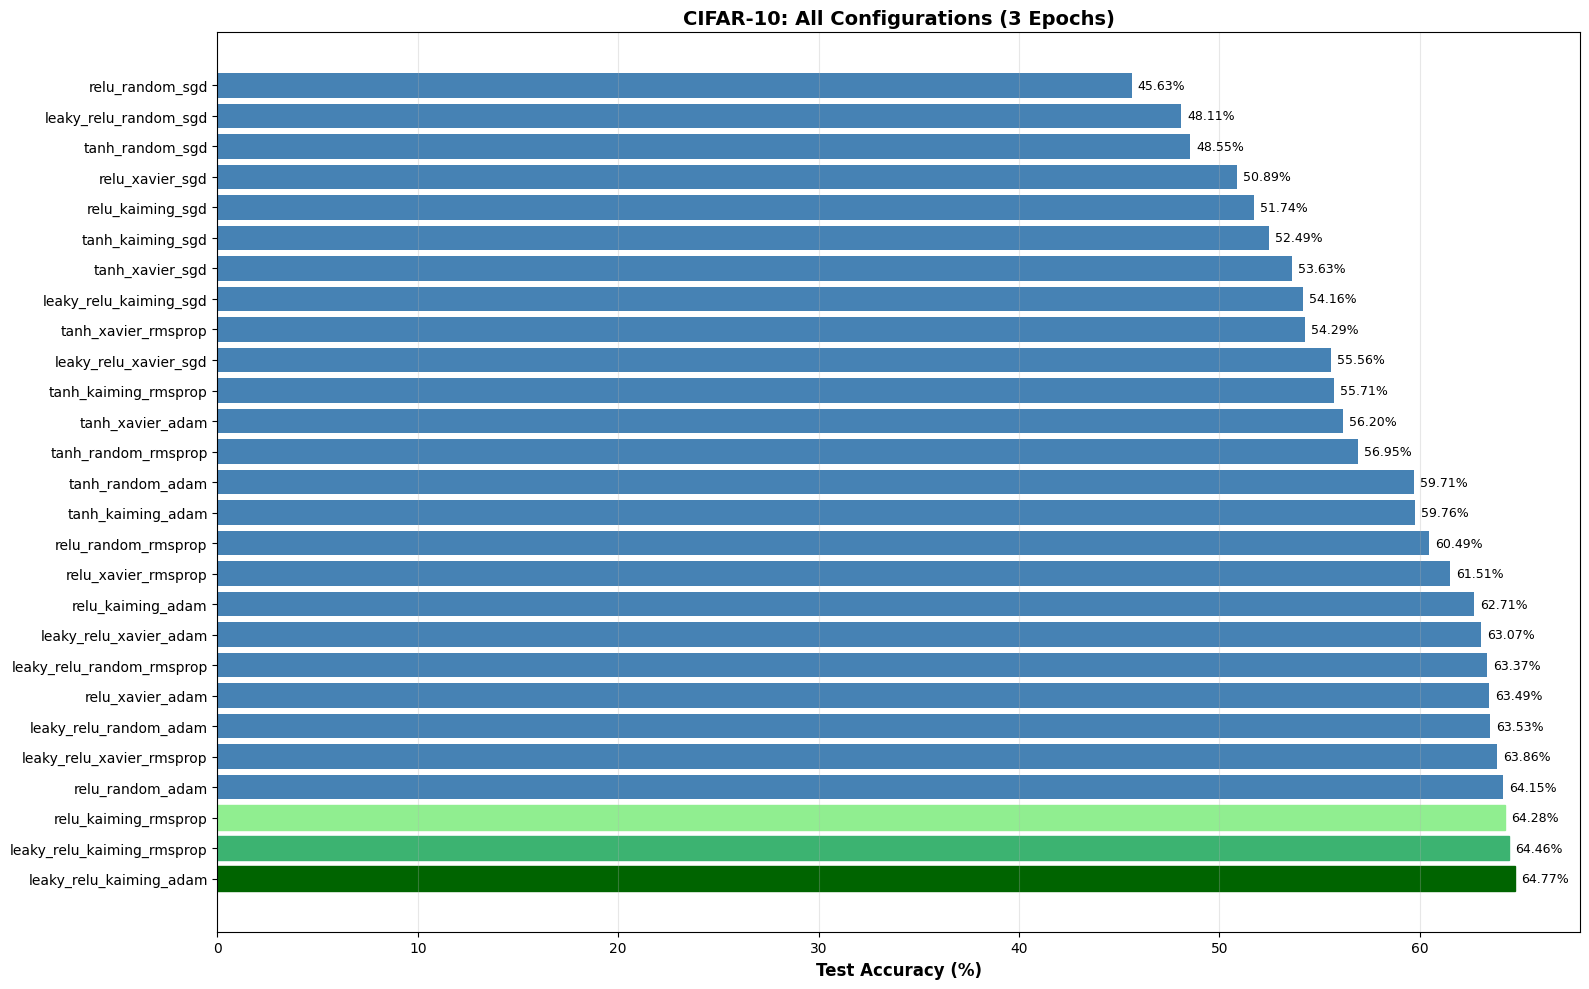

In [11]:
# Save JSON
results_summary = {
    'dataset': 'CIFAR-10',
    'num_epochs': 3,
    'best_config': best_config,
    'best_accuracy': best_acc,
    'all_configs': {config: {
        'best_test_acc': history['best_test_acc'],
        'final_test_acc': history['test_accs'][-1]
    } for config, history in all_results.items()}
}

with open('/content/results/cifar10_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

# Comparison plot
configs = list(all_results.keys())
accuracies = [all_results[c]['best_test_acc'] for c in configs]
sorted_idx = np.argsort(accuracies)[::-1]

plt.figure(figsize=(16, 10))
bars = plt.barh(range(len(configs)), [accuracies[i] for i in sorted_idx],
               color='steelblue')
bars[0].set_color('darkgreen')
if len(bars) > 1: bars[1].set_color('mediumseagreen')
if len(bars) > 2: bars[2].set_color('lightgreen')

plt.yticks(range(len(configs)), [configs[i] for i in sorted_idx], fontsize=10)
plt.xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('CIFAR-10: All Configurations (3 Epochs)',
         fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate([accuracies[j] for j in sorted_idx]):
    plt.text(v + 0.3, i, f'{v:.2f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('/content/results/cifar10_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

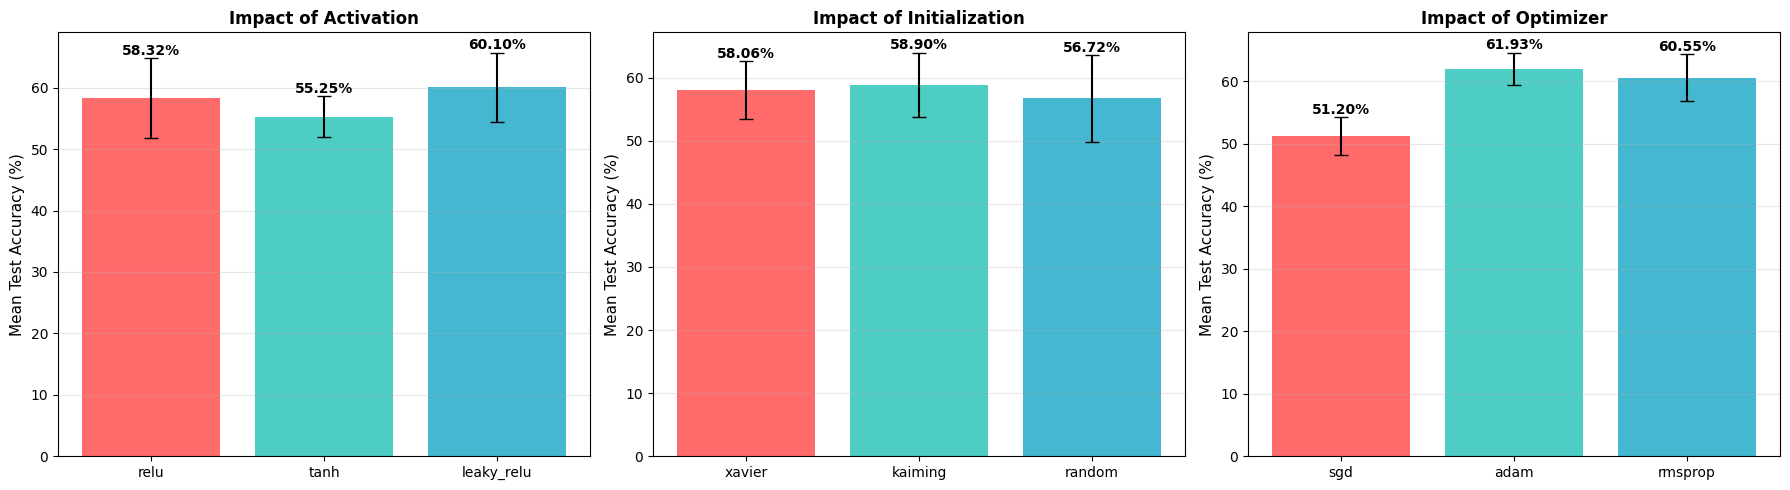

In [12]:
# Analyze by component
activation_results = {act: [] for act in activations}
for config, history in all_results.items():
    for act in activations:
        if config.startswith(act):
            activation_results[act].append(history['best_test_acc'])

init_results = {init: [] for init in initializations.keys()}
for config, history in all_results.items():
    for init in initializations.keys():
        if f'_{init}_' in config:
            init_results[init].append(history['best_test_acc'])

opt_results = {opt: [] for opt in optimizers_config}
for config, history in all_results.items():
    for opt in optimizers_config:
        if config.endswith(opt):
            opt_results[opt].append(history['best_test_acc'])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (results, labels, title) in enumerate([
    (activation_results, activations, 'Activation'),
    (init_results, list(initializations.keys()), 'Initialization'),
    (opt_results, optimizers_config, 'Optimizer')
]):
    means = [np.mean(results[l]) for l in labels]
    stds = [np.std(results[l]) for l in labels]

    axes[i].bar(labels, means, yerr=stds, capsize=5,
               color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
    axes[i].set_ylabel('Mean Test Accuracy (%)', fontsize=11)
    axes[i].set_title(f'Impact of {title}', fontsize=12, fontweight='bold')
    axes[i].grid(axis='y', alpha=0.3)

    for j, v in enumerate(means):
        axes[i].text(j, v + stds[j] + 0.5, f'{v:.2f}%',
                    ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/results/cifar10_component_analysis.png',
           dpi=150, bbox_inches='tight')
plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 238MB/s]


ResNet-18 parameters: 11,173,962
Training ResNet-18...


Epoch 1/3: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s, loss=1.0246, acc=64.27%]


Epoch [1/3]
Train Loss: 1.0246, Train Acc: 64.27%
Test Loss: 0.7189, Test Acc: 75.53%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s, loss=0.7121, acc=75.80%]


Epoch [2/3]
Train Loss: 0.7121, Train Acc: 75.80%
Test Loss: 0.7522, Test Acc: 76.32%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 391/391 [00:45<00:00,  8.58it/s, loss=0.6285, acc=78.60%]


Epoch [3/3]
Train Loss: 0.6285, Train Acc: 78.60%
Test Loss: 0.6432, Test Acc: 78.43%
------------------------------------------------------------


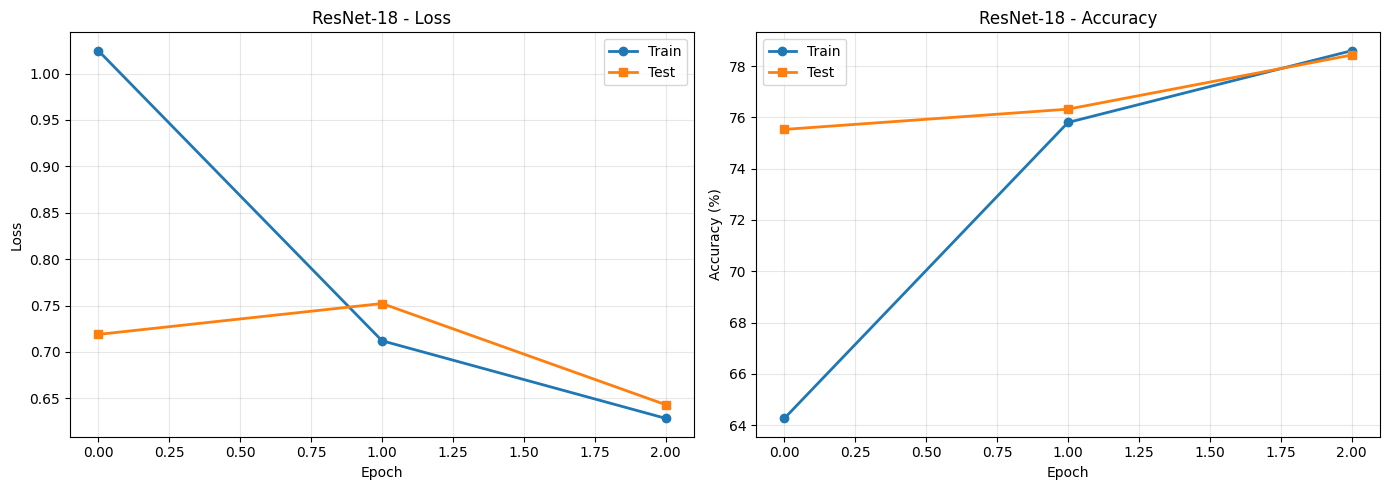

ResNet-18 Best: 78.43%


In [13]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
resnet18.maxpool = nn.Identity()
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = resnet18.to(device)

print(f"ResNet-18 parameters: {sum(p.numel() for p in resnet18.parameters()):,}")

resnet_optimizer = optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=5e-4)
resnet_criterion = nn.CrossEntropyLoss()

print("Training ResNet-18...")
resnet_history = train_model(resnet18, train_loader, test_loader,
                            resnet_criterion, resnet_optimizer,
                            num_epochs=3, device=device,
                            model_name='resnet18_cifar10')

plot_history(resnet_history, 'ResNet-18',
            '/content/results/resnet18_history.png')

print(f"ResNet-18 Best: {resnet_history['best_test_acc']:.2f}%")

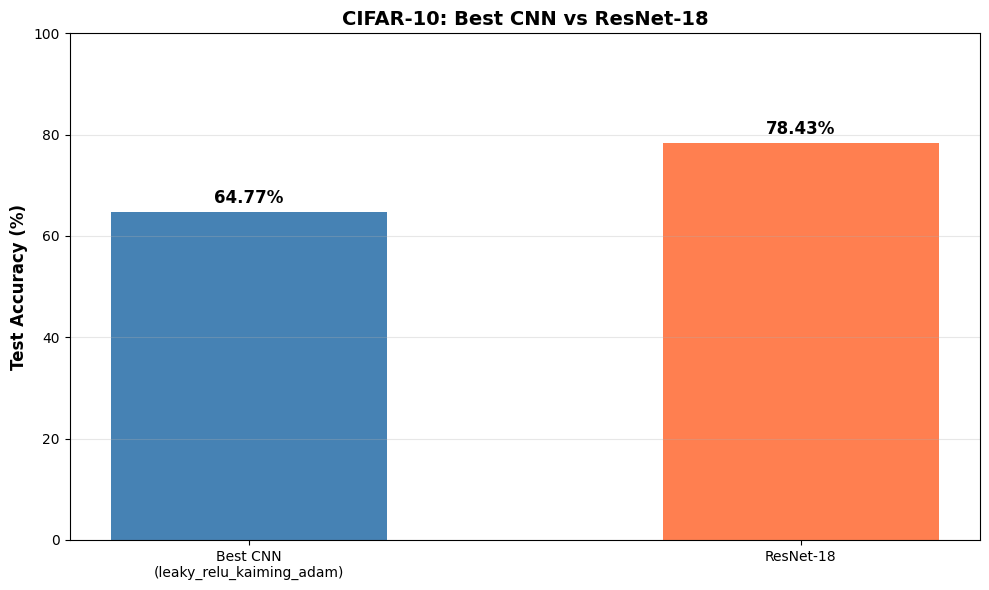

KeyError: 'Best CNN\\n(leaky_relu_kaiming_adam)'

In [15]:
comparison = {
    f'Best CNN\n({best_config})': all_results[best_config]['best_test_acc'],
    'ResNet-18': resnet_history['best_test_acc']
}

plt.figure(figsize=(10, 6))
bars = plt.bar(comparison.keys(), comparison.values(),
              color=['steelblue', 'coral'], width=0.5)

plt.ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('CIFAR-10: Best CNN vs ResNet-18', fontsize=14, fontweight='bold')
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h + 1,
            f'{h:.2f}%', ha='center', va='bottom',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/results/cifar10_final_comparison.png',
           dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest CNN: {comparison[f'Best CNN\\n({best_config})']:.2f}%")
print(f"ResNet-18: {comparison['ResNet-18']:.2f}%")

In [16]:
!cp -r /content/models/* /content/drive/MyDrive/DL_Lab/Experiment4_CIFAR10/
!cp -r /content/results/* /content/drive/MyDrive/DL_Lab/Experiment4_CIFAR10/

print("Saved to: /content/drive/MyDrive/DL_Lab/Experiment4_CIFAR10/")

Saved to: /content/drive/MyDrive/DL_Lab/Experiment4_CIFAR10/


In [17]:
!cd /content && zip -r cifar10_results.zip models/ results/

from google.colab import files
files.download('/content/cifar10_results.zip')

print("\n" + "="*80)
print("CIFAR-10 EXPERIMENT COMPLETE!")
print("="*80)
print(f"Best CNN: {best_config} - {best_acc:.2f}%")
print(f"ResNet-18: {resnet_history['best_test_acc']:.2f}%")
print("="*80)

  adding: models/ (stored 0%)
  adding: models/tanh_xavier_rmsprop_best.pth (deflated 10%)
  adding: models/tanh_xavier_sgd_best.pth (deflated 8%)
  adding: models/tanh_random_rmsprop_best.pth (deflated 10%)
  adding: models/leaky_relu_kaiming_adam_best.pth (deflated 9%)
  adding: models/tanh_kaiming_sgd_best.pth (deflated 8%)
  adding: models/tanh_random_sgd_best.pth (deflated 8%)
  adding: models/relu_random_rmsprop_best.pth (deflated 9%)
  adding: models/resnet18_cifar10_best.pth (deflated 8%)
  adding: models/tanh_kaiming_rmsprop_best.pth (deflated 10%)
  adding: models/relu_xavier_adam_best.pth (deflated 9%)
  adding: models/relu_kaiming_adam_best.pth (deflated 9%)
  adding: models/relu_xavier_rmsprop_best.pth (deflated 9%)
  adding: models/tanh_kaiming_adam_best.pth (deflated 10%)
  adding: models/relu_random_adam_best.pth (deflated 9%)
  adding: models/relu_kaiming_sgd_best.pth (deflated 8%)
  adding: models/tanh_xavier_adam_best.pth (deflated 9%)
  adding: models/leaky_relu_ran

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


CIFAR-10 EXPERIMENT COMPLETE!
Best CNN: leaky_relu_kaiming_adam - 64.77%
ResNet-18: 78.43%
